<img width="300px" src="https://mlflow.org/docs/latest/_static/MLflow-logo-final-black.png">

# Why Mlflow?

A machine learning product is not only depend on code, as standard software development does. It is a combination of not only code, but also the input data and model parameters. Organizations need to:

- Version control the data used to fuel ML models;
- Perform model and experiment tracking and versioning;
- Systematically optimize models through hyperparameter optimization;
- Deploy and monitor models in production environments and keep track of the performance.

MLOps is the name given to the processes and tools developed to manage all these components. 
In recent years, the number of tools has been growing rapidly.  
While there are a number of tools currently available for all these different purposes, Mlflow offers a set of features for individuals and teams in an attempt to solve some of these issues.

**Mlflow** is an open-source platform, backed by Databricks, for managing the lifecycle of machine learning models, through four different pillars:

- By tracking experiments to compare results (**Tracking**);
- By allowing data scientists and ML engineers to create reusable machine learning code (**Projects**);
- By defining a standard format for packaging models and send them to diverse deployment tools (**Models**);
- By providing a centralized repository to collaborative manage the lifecycle of models through versioning, stage transitions and annotations (**Registry**).

Besides providing SDK for common languages (Python, R, Java, Julia), and good integration with popular ML frameworks, such as Scikit-learn, Tensorflow, behond others, it is completely **language and library-agnostic**. One can use it with any framework and programming language, since it also provides a REST interface for exchanging metadata with the server.

<img src="https://www.ambiata.com/images/blog/mlops-tools_files/task-scope.png" style="width: 70%">

Nowadays, there are a lot of MLOps tools.

Be aware, even if a tool offers features for given task, they may tackle it with different levels of depth.   
For example, even though Kubeflow offers experiment tracking, it requires a level of DevOps expertise that most data scientist don't have. It sits on top of Kubernetes and can be seen as orchestrator for common MLOps tools. **Mlflow, on the other hand, is simple and perfect for global EDA and ML tracking**. 

Weights and Biases excels in tracking and reporting, considered to be a great tool for teams focused more on research than deliverables. Although it provides deployment capabilities, such as the ability for packaging models into Docker containers, it is not one of its strong suits.

Comet.ml is another great example of tool that provides most of the same features as Mlflow, with superior tracking capabilities. It is, however, a proprietary and licensed tool, just like W&B.

# Is it perfect?

**NO.**

Although Mlflow is a great tool, it still lacks behind its competitors in some areas:

- It is not easy to compare different experiments.
- Even though super useful, autolog features are still experimental and sometimes buggy.
- Most plots are not embedded widgets, but stored as artifacts.
- Deployment containers are far from optimized, and they are not 100% reliable for a production environment.
- ACL for registry management is only available through Databricks managed version.

**In general, Mlflow offers a basic set of features if all you want is experiment tracking.   
On the other hand, it is an open-source, language and library-agnostic and provides an interesting set of model management features.**

# Mlflow tracking

Mlflow offers an API for tracking and recording machine learning experiments metadata, images, and artifacts.   
It also provides a nice UI for checking and querying the latter.

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature
import pandas as pd

### Scikit-learn DecisionTree

First, we need to create or set a Mlflow experiment. An experiment groups `runs`, or model trainings/executions.

In [2]:
# Set an Mlflow experiment
mlflow.set_experiment('iris-dt-sklearn')

INFO: 'iris-dt-sklearn' does not exist. Creating a new experiment


Following that, we need to load our dataset and split it into training and test sets.

In [3]:
# Load iris dataset
iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
X_train, X_test, y_train, y_test = train_test_split(
        df_iris, iris.target, random_state=0)

In [4]:
df_iris.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Let's also do a quick EDA to check for missing values.

In [5]:
df_iris.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64

In [6]:
df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
pd.Series(iris.target).value_counts()

0    50
1    50
2    50
dtype: int64

We decided to use a Decision Tree as our classifier. Given that our feature columns are complete and we are using a tree-based classifier, there is no need for normalization/standardization of the features. Let's proceed by feeding our model the training data and getting the test results.

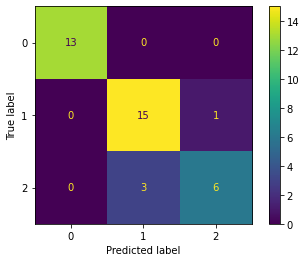

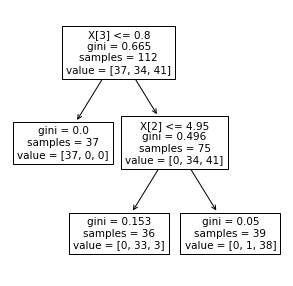

In [8]:
# Start run
with mlflow.start_run(run_name='first_run'):
    # Define and log hyperparameters
    hps = {
        'random_state': 0,
        'max_depth': 2
    }
    mlflow.log_params(hps)

    # Fit model
    dt = DecisionTreeClassifier(**hps)
    dt = dt.fit(X_train, y_train)

    # Get test set predictions
    y_pred = dt.predict(X_test)
    metrics = classification_report(y_test, y_pred, output_dict=True)
    mlflow.log_metrics({
        'accuracy': metrics['accuracy'],
        'f1-score': metrics['macro avg']['f1-score']
    })
    
    # Set Mlflow tags (default and custom)
    mlflow.set_tags({
        'mlflow.user': 'pedro.martins@ds.pt',
        'mlflow.source.type': 'NOTEBOOK',
        'project': 'iris-test-dt'
    })

    # Plot confusion matrix and log artifact
    cm = confusion_matrix(y_test, y_pred, labels=dt.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
    mlflow.log_figure(disp.plot().figure_, 'cm.png')

    # Plot tree configuration and log figure
    f, ax = plt.subplots(1, 1, figsize=(5, 5))
    tree.plot_tree(dt, ax=ax)
    mlflow.log_figure(f, 'tree.png')

    # Define input and output signatures
    signature = infer_signature(X_train, y_train)

    # Log model
    mlflow.sklearn.log_model(dt, 'model', signature=signature)

Access `http://<your-docker-machine-ip>:5000` and we will go through the Mlflow tracking UI.

### TensorFlow 

In [9]:
# TensorFlow and tf.keras
import tensorflow as tf
import mlflow.tensorflow
import mlflow.keras

We are going to load Fashion MNIST data from Tensorflow Keras datasets and normalize the training and test data.
We are loading images of fashion objects. The provided images are 3-dimensional tensors, whose values range from 0 to 255. Neural networks best behave when input values range from 0.0 to 1.0, therefore we need to normalize it.

<img src="https://www.tensorflow.org/tutorials/keras/classification_files/output_m4VEw8Ud9Quh_0.png">

In [10]:
# Load input data from tf.keras.datasets
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [11]:
# Normalize train and test data.
train_images = train_images / 255.0
test_images = test_images / 255.0

In [12]:
# Set a Mlflow experiment and turn on autologging
mlflow.set_experiment('tf-autolog-experiment')

INFO: 'tf-autolog-experiment' does not exist. Creating a new experiment


In [13]:
# Create Keras model
mlflow.tensorflow.autolog()

with mlflow.start_run():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=3)

    # Notice these metrics are not logged
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

    print('\nTest accuracy:', test_acc)

2021/12/09 18:54:17 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Epoch 1/3
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4953 - accuracy: 0.8261
Epoch 2/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3735 - accuracy: 0.8667
Epoch 3/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3356 - accuracy: 0.8782
INFO:tensorflow:Assets written to: /tmp/tmpma2rblz8/model/data/model/assets
313/313 - 1s - loss: 0.3639 - accuracy: 0.8692 - 943ms/epoch - 3ms/step

Test accuracy: 0.8691999912261963


Let's go to the UI again and check how our loss and accuracy behaves during the training epochs.

Besides being an experimental feature, subject to bugs, not every metric is automatically tracked by Mlflow.   
For more information on which metrics are tracked, check the [docs](https://mlflow.org/docs/latest/tracking.html#tensorflow-and-keras-experimental).

## Hyperparameter tuning using XGBoost and HyperOpt

In [14]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb
import numpy as np
import mlflow.xgboost

In [15]:
# Load Iris dataset from scikit-learn and configure XGBoost data matrices
iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
X_train, X_test, y_train, y_test = train_test_split(
        df_iris, iris.target, random_state=0)

In [16]:
# Set hyperparameter space
space={
    'max_depth': hp.quniform("max_depth", 2, 6, 1),
    'gamma': hp.uniform ('gamma', 1, 9),
    'reg_alpha' : hp.quniform('reg_alpha', 0, 5, 1),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.2, 1)
}

In [17]:
# Set Mlflow experiment
mlflow.set_experiment('xgboost-autohp-test')
mlflow.xgboost.autolog()

2021/12/09 18:58:24 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


INFO: 'xgboost-autohp-test' does not exist. Creating a new experiment


In [18]:
# Configure training data matrices (always after setting up autolog to infer signature)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# Create training function
def hyperparameter_tuning(space):
    with mlflow.start_run(nested=True, run_name='child_run'):
        # specify parameters via map
        param = {
            'max_depth': int(space['max_depth']),
            'gamma': space['gamma'],
            'reg_alpha': space['reg_alpha'],
            'reg_lambda': space['reg_lambda'],
            'colsample_bytree': space['colsample_bytree'],
            'min_child_weight': 3,
            'eta': 0.3,  # the training step for each iteration
            'verbosity': 1,  # logging mode - quiet
            'objective': 'multi:softprob',  # error evaluation for multiclass training
            'eval_metric': 'mlogloss',
            'num_class': pd.Series(iris.target).nunique()
        }
        num_round = 2
        bst = xgb.train(param, dtrain, num_round)

        # make prediction
        preds = bst.predict(dtest)
        best_preds = np.asarray([np.argmax(line) for line in preds])
        f1 = f1_score(best_preds, y_test, average='macro')
        mlflow.log_param('f1_score', f1)

        #change the metric if you like
        return {'loss': -f1, 'status': STATUS_OK, 'model': bst}

In [ ]:
# Run hyperparameter optimization with HyperOpt
with mlflow.start_run(run_name='parent_run'):
    trials = Trials()
    best = fmin(
        fn=hyperparameter_tuning,
        space=space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials
    )

Let's now access the UI and plot the hyperparameters and metrics.   
Check which hyperparameter ranges had the most impact on the model F1 score.


Finally, we want to retrive the best model, but we also need to know the ID of our experiment.

In [19]:
# List experiments
mlflow.list_experiments()

[<Experiment: artifact_location='s3://mlflow/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='s3://mlflow/8', experiment_id='8', lifecycle_stage='active', name='xgboost-hyperopt-auto', tags={}>,
 <Experiment: artifact_location='s3://mlflow/10', experiment_id='10', lifecycle_stage='active', name='iris-dt-sklearn', tags={}>,
 <Experiment: artifact_location='s3://mlflow/11', experiment_id='11', lifecycle_stage='active', name='tf-autolog-experiment', tags={}>,
 <Experiment: artifact_location='s3://mlflow/12', experiment_id='12', lifecycle_stage='active', name='xgboost-autohp-test', tags={}>]

In [20]:
# Search through experiment runs
df = mlflow.search_runs([8], order_by=['metrics.f1_score DESC'])
df.head(1)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.f1_score,params.num_class,params.gamma,params.reg_lambda,...,params.eta,params.verbose_eval,params.maximize,params.reg_alpha,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.parentRunId,tags.mlflow.source.type,tags.mlflow.runName
0,e4d1eb8a9c4449649c733448da50dbbe,8,FINISHED,s3://mlflow/8/e4d1eb8a9c4449649c733448da50dbbe...,2021-12-09 17:55:29.765000+00:00,2021-12-09 17:55:33.485000+00:00,0.971703,3,6.062161675181252,0.21127755276478144,...,0.3,True,None,2.0,"[{""run_id"": ""e4d1eb8a9c4449649c733448da50dbbe""...",root,/opt/conda/lib/python3.8/site-packages/ipykern...,700bdacd49d6445a8e07b932e1e71ec5,LOCAL,child_run


Having access to the `run_id` of the best performing model in our experiment, we can again get the model artifact, as well as other artifacts stored in our repo.

In [21]:
# Get best model artifact
bst = mlflow.xgboost.load_model(f'runs:/{df.iloc[0].run_id}/model')

In [22]:
bst

In [23]:
# Compute again the F1-Score against the test set
best_preds = np.asarray([np.argmax(line) for line in bst.predict(dtest)])
f1_score(best_preds, y_test, average='macro')

0.9717034521788342

In [24]:
# Download feature importance image artifact
client = MlflowClient()
local_path = client.download_artifacts(df.iloc[0].run_id, 'feature_importance_weight.png', '.')

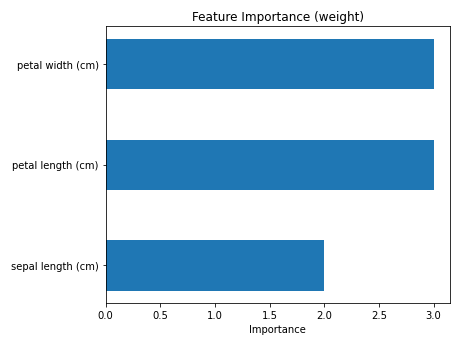

In [25]:
# Display image artifact
from IPython.display import Image
Image(filename='feature_importance_weight.png')

## Mlflow Projects

Our next goal is to create a reproducible code base for our model. Mlflow provides a format for packaging data science code so that we are able to easily reuse it.

We only need four things:

- A folder with the name of the project;
- A `conda.yml` file or a docker image for the running environment;
- A `.sh` or `.py` entrypoint file;
- A `MLproject` file that contains the project definition.

Having all these, we can simply run in our terminal:

```
mlflow run <PROJECT_NAME> --experiment-name <EXPERIMENT_NAME> [-P parameter1=value1 ...]
```

## Mlflow Models

An MLflow Model is a standard format for packaging machine learning models that can be used in a variety of downstream tools—for example, real-time serving through a REST API or batch inference on Apache Spark. The format defines a convention that lets you save a model in different "flavors" that can be understood by different downstream tools.

Let's check our XGBoost model artifacts.

In [26]:
# Load Python function version of XGBoost model
pyfunc_bst = mlflow.pyfunc.load_model(f'runs:/{df.iloc[0].run_id}/model')

In [27]:
# Print model
pyfunc_bst

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: e4d1eb8a9c4449649c733448da50dbbe

In [28]:
# Predict with sample input
pyfunc_bst.predict([{
    'sepal length (cm)': 1.0,
    'sepal width (cm)': 2.0,
    'petal length (cm)': 3.0,
    'petal width (cm)': 1.0,
}])

array([[0.4125902 , 0.42128867, 0.16612116]], dtype=float32)

Mlflow Models provide a standard format so that one can load a model in different flavors. For example:
- A pickled scikit-learn object that can be loaded into a Scikit-learn pipeline.
- A generic Python function that can be loaded into any compatible Python environment, or any of the available deployment tools.

If any of the available flavors that Mlflow provides does not fit your needs, one can define a custom model:

In [29]:
import mlflow.pyfunc

# Define the model class
class AddN(mlflow.pyfunc.PythonModel):
    
    def __init__(self, n):
        self.n = n
        
    def predict(self, context, model_input):
        return model_input.apply(lambda x: x + self.n)

# Construct and save the model
model_path = 'add-n-model'
add10_model = AddN(n=10)
mlflow.pyfunc.save_model(path=model_path, python_model=add10_model)

In [30]:
# Load the model in `python_function` format
loaded_model = mlflow.pyfunc.load_model(model_path)

# Evaluate the model
model_input = pd.DataFrame([range(10)])
model_output = loaded_model.predict(model_input)
assert model_output.equals(pd.DataFrame([range(10, 20)]))

In [33]:
model_input

,0,1,2,3,4,5,6,7,8,9
0,0,1,2,3,4,5,6,7,8,9


In [32]:
model_output

,0,1,2,3,4,5,6,7,8,9
0,10,11,12,13,14,15,16,17,18,19


## Built-in deployment tools

Mlflow provides a series of built-in deployment tools, so that one can serve a model locally, or remotely in Azure ML, AWS SageMaker, or as a Apache Spark UDF.

The tool builds a Docker images with REST API endpoints using Mlflow Python functions, that accepts data in multiple formats as POST input to the `/invocations` endpoint path:

| Description                                                    | Content-Type
|:---------------------------------------------------------------|:-------------------------------------------------------------------------|
| JSON-serialized pandas DataFrames in the split orientation <br />  `pandas_df.to_json(orient='split')`     | `application/json` or `application/json; format=pandas-split` |
| JSON-serialized pandas DataFrames in the records orientation <br />   | `application/json; format=pandas-records`                                |
| CSV-serialized pandas DataFrames <br /> `pandas_df.to_csv()`                           | `text/csv`                                                                |
| Tensor input formatted as described in TF Serving’s API docs. | `application/json`|

To serve a model locally, one can simply run:

```
mlflow models serve -m "models:/<MODEL_NAME>/<MODEL_VERSION_OR_STAGE>" -p 1234
```

Where `<MODEL_VERSION_OR_STAGE>` may correspond to the model version or the stage (Staging, Production).

In [34]:
import requests
r = requests.post(
    'http://127.0.0.1:1234/invocations',
    headers={'Content-Type': 'application/json'},
    data=X_test.to_json(orient='split'),
)

In [35]:
r.json()

[[0.20574191212654114, 0.20313237607479095, 0.5911257266998291],
 [0.21198156476020813, 0.5763348340988159, 0.21168358623981476],
 [0.33853626251220703, 0.32340335845947266, 0.3380604088306427],
 [0.20574191212654114, 0.20313237607479095, 0.5911257266998291],
 [0.5760100483894348, 0.20729750394821167, 0.2166924923658371],
 [0.20574191212654114, 0.20313237607479095, 0.5911257266998291],
 [0.5760100483894348, 0.20729750394821167, 0.2166924923658371],
 [0.21198156476020813, 0.5763348340988159, 0.21168358623981476],
 [0.21198156476020813, 0.5763348340988159, 0.21168358623981476],
 [0.21198156476020813, 0.5763348340988159, 0.21168358623981476],
 [0.24214182794094086, 0.3717319667339325, 0.38612625002861023],
 [0.21198156476020813, 0.5763348340988159, 0.21168358623981476],
 [0.21198156476020813, 0.5763348340988159, 0.21168358623981476],
 [0.21198156476020813, 0.5763348340988159, 0.21168358623981476],
 [0.21198156476020813, 0.5763348340988159, 0.21168358623981476],
 [0.5760100483894348, 0.207

In [37]:
# Get latest versions on Production
client.get_latest_versions('test-xgboost-model', stages=["Production"])

[<ModelVersion: creation_timestamp=1639077690149, current_stage='Production', description='This is the version version. Please check the results and review them.', last_updated_timestamp=1639077869893, name='test-xgboost-model', run_id='1df638ea357b4e80ac3ab898f3936ede', run_link='', source='s3://mlflow/13/1df638ea357b4e80ac3ab898f3936ede/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>]

# Resources and references

- [Mlflow](https://mlflow.org)
- [ML workspace](https://github.com/ml-tooling/ml-workspace)
- [mlflow-docker](https://github.com/Toumash/mlflow-docker)
- [Ambiata - MLOps tools](https://www.ambiata.com/blog/2020-12-07-mlops-tools/)
- [The Cheesy analogy of Mlflow and Kubeflow](https://servian.dev/the-cheesy-analogy-of-mlflow-and-kubeflow-715a45580fbe)
- [Machine learning tools comparison](https://www.netguru.com/blog/machine-learning-tools-comparison)
- [Decision Trees - scikit-learn](https://scikit-learn.org/stable/modules/tree.html#classification)
- [Basic classification: Classify images of clothing](https://www.tensorflow.org/tutorials/keras/classification)
- [HyperParameter Tuning — Hyperopt Bayesian Optimization](https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9)